In [1]:
import os
from glob import glob

import numpy as np
import h5py
import cv2

import torch 
from torch.utils.data import Dataset
from torchvision import transforms


import matplotlib as mpl
import matplotlib.pyplot as plt



%matplotlib inline

In [2]:
curr_dir=os.getcwd()
curr_dir

'/home/rmajumd/2024/ML_in_image_synthesis/Cityscapes/Cityscapes'

In [3]:
root= os.path.join(curr_dir,"cityscapes_dataset")
root

'/home/rmajumd/2024/ML_in_image_synthesis/Cityscapes/Cityscapes/cityscapes_dataset'

In [4]:
class CityScapes():
    def __init__(self, root, split='train', return_paths=False,transform=None):
        self.root = root
        self.return_paths = return_paths

        self.rgb_paths = glob(os.path.join(root, 'leftImg8bit', split, '**/*.png'), recursive=True)
        self.mask_paths = glob(os.path.join(root, 'gtFine', split, '**/*labelIds.png'), recursive=True)
        self.disparity_paths = glob(os.path.join(root, 'disparity', split, '**/*.png'), recursive=True)
        
        # Print the first few elements to verify they are populated
        # print("RGB paths:", self.rgb_paths[:1])
        # print("Mask paths:", self.mask_paths[:1])
        # print("Disparity paths:", self.disparity_paths[:1])


    def __getitem__(self, idx):
        
        rgb_path = self.rgb_paths[idx]
        mask_path = self.mask_paths[idx]
        disparity_path = self.disparity_paths[idx]
        
        
        
        # Check if files exist
        if not os.path.exists(rgb_path):
            raise FileNotFoundError(f"RGB file not found: {rgb_path}")
        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Mask file not found: {mask_path}")
        if not os.path.exists(disparity_path):
            raise FileNotFoundError(f"Disparity file not found: {disparity_path}")
            
        
            
                
        rgb_image = cv2.cvtColor(cv2.imread(rgb_path), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        disparity = cv2.imread(disparity_path, cv2.IMREAD_UNCHANGED)


        if self.return_paths:
            return rgb_image, (mask, disparity), self.rgb_paths[idx], (self.mask_paths[idx], self.disparity_paths[idx])

        return rgb_image, (mask, disparity)
    
    def __len__(self):
        print(f"Number of RGB images: {len(self.rgb_paths)}")
        print(f"Number of Mask images: {len(self.mask_paths)}")
        print(f"Number of Disparity images: {len(self.disparity_paths)}")
        return len(self.rgb_paths)

In [5]:
dataset = CityScapes(root, split='train')
print("Dataset length:", len(dataset))

Number of RGB images: 2975
Number of Mask images: 2975
Number of Disparity images: 2975
Dataset length: 2975


In [16]:
# help(dataset)

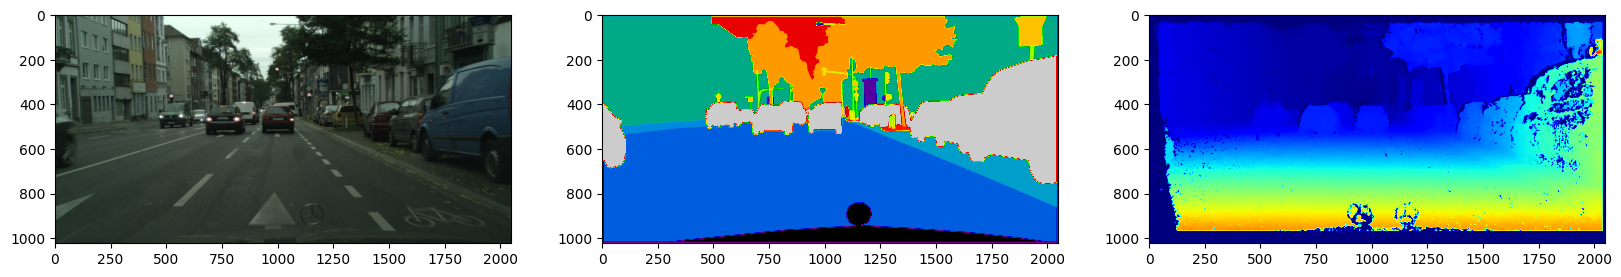

In [25]:
rgb_image, (mask, disparity) = dataset[122]

_, ax = plt.subplots(1, 3, figsize=(20, 8))
ax[0].imshow(rgb_image)
ax[1].imshow(mask, cmap='nipy_spectral')
ax[2].imshow(disparity, cmap='jet')



# testing

In [26]:
# from glob import glob
# import os

# rgb_paths = glob(os.path.join(root, 'leftImg8bit', 'train', '**/*.png'), recursive=True)
# mask_paths = glob(os.path.join(root, 'gtFine', 'train', '**/*labelIds.png'), recursive=True)
# disparity_paths = glob(os.path.join(root, 'disparity', 'train', '**/*.png'), recursive=True)

# print("RGB images:", len(rgb_paths))
# print("Masks:", len(mask_paths))
# print("Disparity images:", len(disparity_paths))


# pipeline to obtain depthmaps

In [27]:
# get sizes
h, w = disparity.shape
h2, w2 = int(h*0.8), int(w*0.8)

# remove most noisy bottom area
# crop bottom noise and resize
# disparity = cv2.resize(disparity[50:h2, 100:], (w,h))
cropped_disparity = disparity[50:int(h * 0.8), 100:]
disparity_resized = cv2.resize(cropped_disparity, (w, h))


# # remove noisy top and left areas with border replicate
# # crop top and left and use copyMakeBorder to replicate the edges
# disparity = cv2.copyMakeBorder(disparity[:, 50:], 
#                                top=0, 
#                                bottom=0, 
#                                left=50, 
#                                right=0, 
#                                borderType=cv2.BORDER_REFLECT)

# Inpaint invalid Disparity and blur to further reduce the noise

In [28]:
# inpaint invalid disparity
inpaint_radius = 12
disparity = cv2.inpaint(disparity, np.uint8(255*(disparity <= 1)), inpaintRadius=inpaint_radius, flags=cv2.INPAINT_TELEA)

# blur to reduce noise
disparity = cv2.medianBlur(disparity, 5)
disparity = disparity.astype(np.float32)

baseline = 0.209313 # meters

# focal lengths (pixels)
fx = 2262.52 
fy = 2265.3017905988554 

depth = baseline * fx / (disparity + 0.1)

# Scale to get true disparity

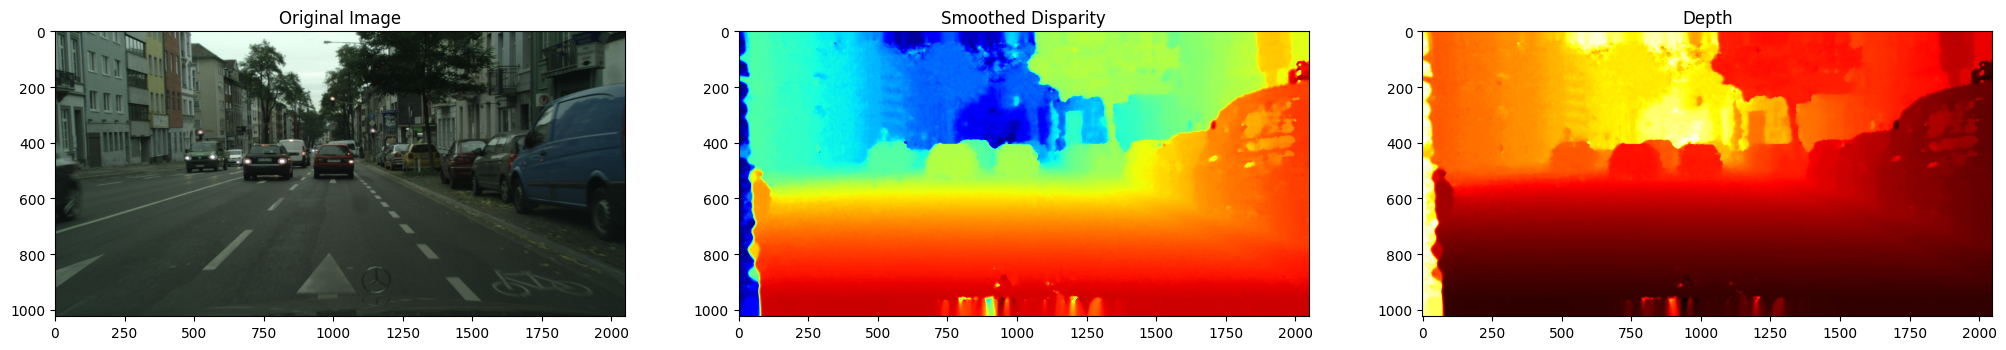

In [33]:
disparity_float = disparity.astype(np.float32)
# disparity[disparity > 0] = (disparity[disparity > 0] - 1) / 256

valid_mask = disparity_float > 0
disparity_float[valid_mask] = (disparity_float[valid_mask] - 1) / 256.0

baseline = 0.209313 # meters

# focal lengths (pixels)
fx = 2262.52 
fy = 2265.3017905988554 

depth = baseline * fx / (disparity + 0.1)

depth = np.zeros_like(disparity_float, dtype=np.float32)
depth[valid_mask] = baseline * fx / (disparity_float[valid_mask] + 0.1)

# Clip the depth map to the maximum valid depth
depth_clipped = np.clip(depth, 0, 500)


_, ax = plt.subplots(1, 3, figsize=(25, 15))
ax[0].imshow(rgb_image)
ax[0].set_title("Original Image")
ax[1].imshow(np.log(disparity_float + 1), cmap='jet')
ax[1].set_title("Smoothed Disparity")
ax[2].imshow(np.log(depth_clipped), cmap='hot')
ax[2].set_title("Depth");

# compute depth

In [ ]:
# get sizes
h, w = disparity.shape
h2, w2 = int(h*0.8), int(w*0.8)

# remove most noisy bottom area
# crop bottom noise and resize
disparity = cv2.resize(disparity[50:h2, 100:], (w,h))


# inpaint invalid disparity
inpaint_radius = 12
disparity = cv2.inpaint(disparity, np.uint8(255*(disparity <= 1)), inpaintRadius=inpaint_radius, flags=cv2.INPAINT_TELEA)

# blur to reduce noise
disparity = cv2.medianBlur(disparity, 5)



disparity = disparity.astype(np.float32)
disparity[disparity > 0] = (disparity[disparity > 0] - 1) / 256

baseline = 0.209313 # meters

# focal lengths (pixels)
fx = 2262.52 
fy = 2265.3017905988554 

depth = baseline * fx / (disparity + 0.1)

depth = np.clip(depth, 0, 500)


_, ax = plt.subplots(1, 3, figsize=(25, 15))
ax[0].imshow(rgb_image)
ax[0].set_title("Original Image")
ax[1].imshow(np.log(disparity + 1), cmap='jet')
ax[1].set_title("Smoothed Disparity")
ax[2].imshow(np.log(depth), cmap='hot')
ax[2].set_title("Depth");

In [23]:
depth = np.clip(depth, 0, 500)

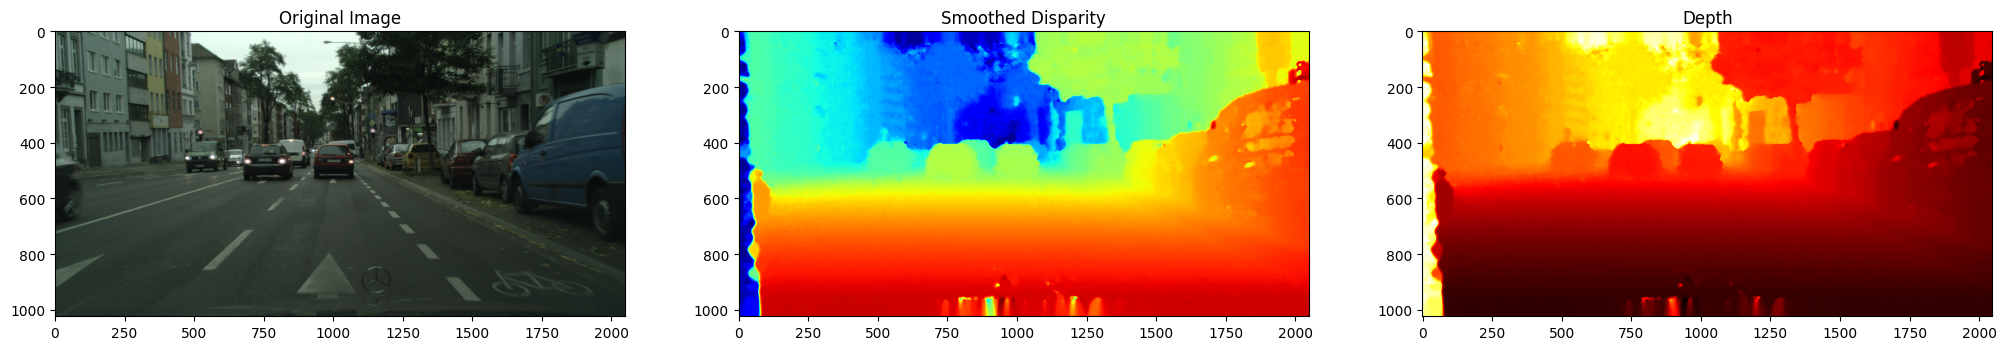

In [24]:
_, ax = plt.subplots(1, 3, figsize=(25, 15))
ax[0].imshow(rgb_image)
ax[0].set_title("Original Image")
ax[1].imshow(np.log(disparity + 1), cmap='jet')
ax[1].set_title("Smoothed Disparity")
ax[2].imshow(np.log(depth), cmap='hot')
ax[2].set_title("Depth");

In [ ]:
# depth = folder with depth as .png img
# depth2 = folder with depth as .npy

# note for above two approaches depth is clipped to 500meters
# depth3 = folder with depth as .npy and not clipped

In [6]:
def compute_depth(disparity : np.ndarray, 
                  w : int = 2048, 
                  h : int = 1024, 
                  inpaint_radius : int = 12, 
                  baseline : float = 0.209313, 
                  f : float = 2262.52, 
                  max_depth : int = 500) -> np.ndarray:
    """ Computes smooth depth map from disparity 
        Inputs:
            disparity - uint16 dispairty image, 
            w - disparity width, 
            h - disparity height, 
            inpaint_radius - inpainting radius, 
            baseline stereo baseline distance (meters), 
            f - camera focal length (pixels) 
                For CityScapes:
                    fx = 2262.52 
                    fy = 2265.3017905988554 
            max_depth - maximum valid depth (meters)
        Outputs: 
            depth - computed depth map
        """
    
    """ NOTE: For training, need to process all input images just like this! """
    cropped_disparity = disparity[50:int(h * 0.8), 100:]
    disparity_resized = cv2.resize(cropped_disparity, (w, h))

    # Inpaint invalid disparity regions if `inpaint_radius` is specified
    if inpaint_radius:
        invalid_mask = np.uint8(255 * (disparity_resized <= 1))
        disparity_resized = cv2.inpaint(disparity_resized, 
                                        invalid_mask, 
                                        inpaintRadius=inpaint_radius, 
                                        flags=cv2.INPAINT_TELEA)

    # Apply median blur to reduce noise
    disparity_smoothed = cv2.medianBlur(disparity_resized, 5)

    # Convert disparity to float and scale to get true disparity
    disparity_float = disparity_smoothed.astype(np.float32)
    valid_mask = disparity_float > 0
    disparity_float[valid_mask] = (disparity_float[valid_mask] - 1) / 256.0

    # Compute depth map using the baseline and focal length
    depth = np.zeros_like(disparity_float, dtype=np.float32)
    depth[valid_mask] = baseline * f / (disparity_float[valid_mask] + 0.1)

    # Clip the depth map to the maximum valid depth
    depth_clipped = np.clip(depth, 0, max_depth)

    return depth_clipped

In [7]:
dataset = CityScapes(root, split='train', return_paths=True)

In [12]:
rgb_image, (_, disparity), _, (_, disparity_path) = dataset[142]

In [13]:
# compute depth
disp = disparity.astype(np.float32)
disp[disp > 0] = (disp[disp > 0] - 1) / 256
og_depth =  0.209313 * 2262.52 / (disp + 0.1)


# compute smoothed depth
depth1 = compute_depth(disparity)
depth2 = compute_depth(disparity, inpaint_radius=12)

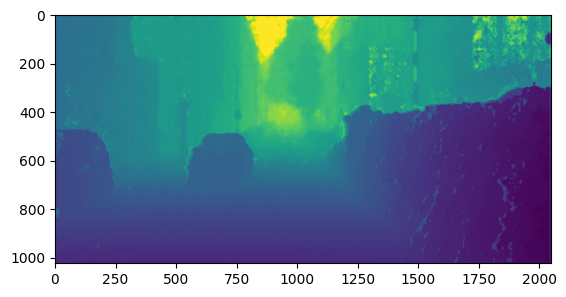

In [14]:
plt.imshow(np.log(depth2))

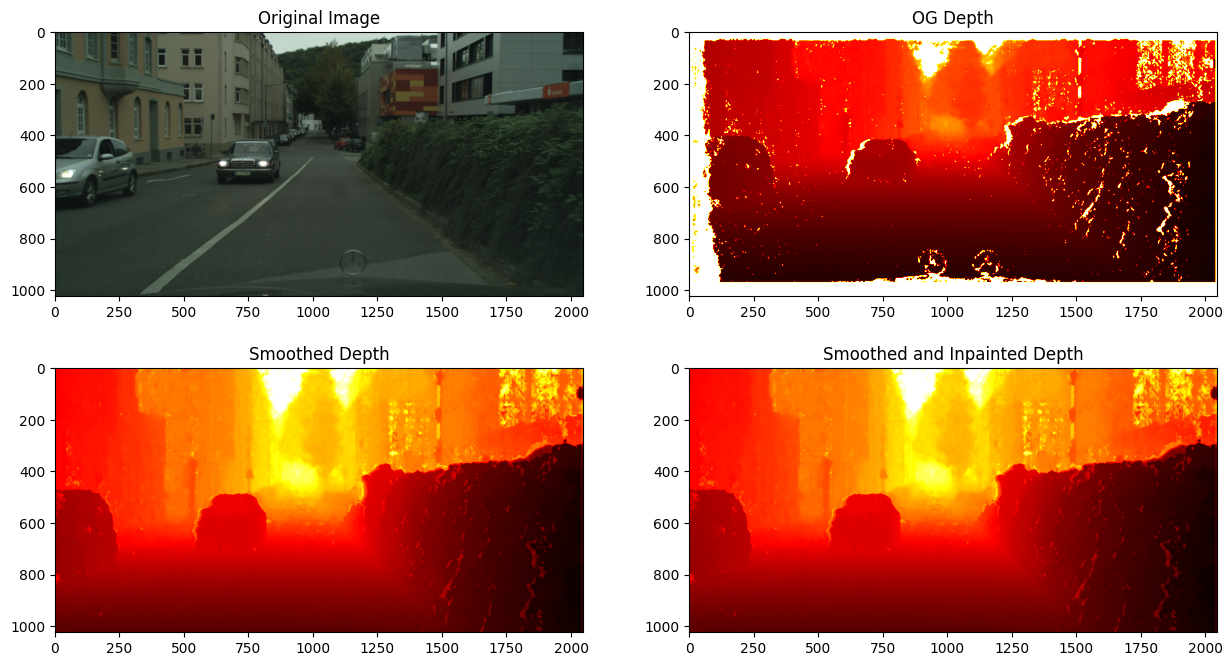

In [15]:
_, ax = plt.subplots(2, 2, figsize=(15, 8))
ax[0, 0].imshow(rgb_image)
ax[0, 0].set_title("Original Image")
ax[0, 1].imshow(np.log(og_depth), cmap='hot')
ax[0, 1].set_title("OG Depth")
ax[1, 0].imshow(np.log(depth1), cmap='hot')
ax[1, 0].set_title("Smoothed Depth")
ax[1, 1].imshow(np.log(depth2), cmap='hot')
ax[1, 1].set_title("Smoothed and Inpainted Depth");

# create depth folder

In [16]:
dirpath = os.path.basename(disparity_path.replace('disparity', 'depth2'))
dirpath

'aachen_000142_000019_depth2.png'

In [17]:
dirpath, name = os.path.split(disparity_path.replace('disparity', 'depth2'))
dirpath, name

('/home/rmajumd/2024/ML_in_image_synthesis/Cityscapes/Cityscapes/cityscapes_dataset/depth2/train/aachen',
 'aachen_000142_000019_depth2.png')

In [18]:
os.path.exists(dirpath)

False

In [19]:
try:
    os.mkdir(dirpath)
except:
    try:
        os.mkdir(os.path.split(dirpath)[0])
    except:
        os.mkdir(os.path.split(os.path.split(dirpath)[0])[0])

In [20]:
# create depth folder
depth_folder = os.path.join(root, 'depth2')
if not os.path.exists(depth_folder):
    os.mkdir(depth_folder)

In [ ]:
for split in ('train', 'val', 'test'):
    # create dir for split
    split_dir = os.path.join(depth_folder, split)
    if not os.path.exists(split_dir):
        os.mkdir(split_dir)

    # get dataset
    dataset = CityScapes(root, split=split, return_paths=True)

    # get depth map for all disparities
    for i in range(len(dataset)):
        _, (_, disparity), _, (_, disparity_path) = dataset[i]
        depth = compute_depth(disparity)

        savepath = disparity_path.replace('disparity', 'depth2').replace('.png','.npy')
        dirname, _= os.path.split(savepath)
        if not os.path.exists(dirname):
            os.mkdir(dirname)

        # cv2.imwrite(savepath, depth)
        np.save(savepath, depth)


        # break


    # break

Number of RGB images: 2975
Number of Mask images: 2975
Number of Disparity images: 2975


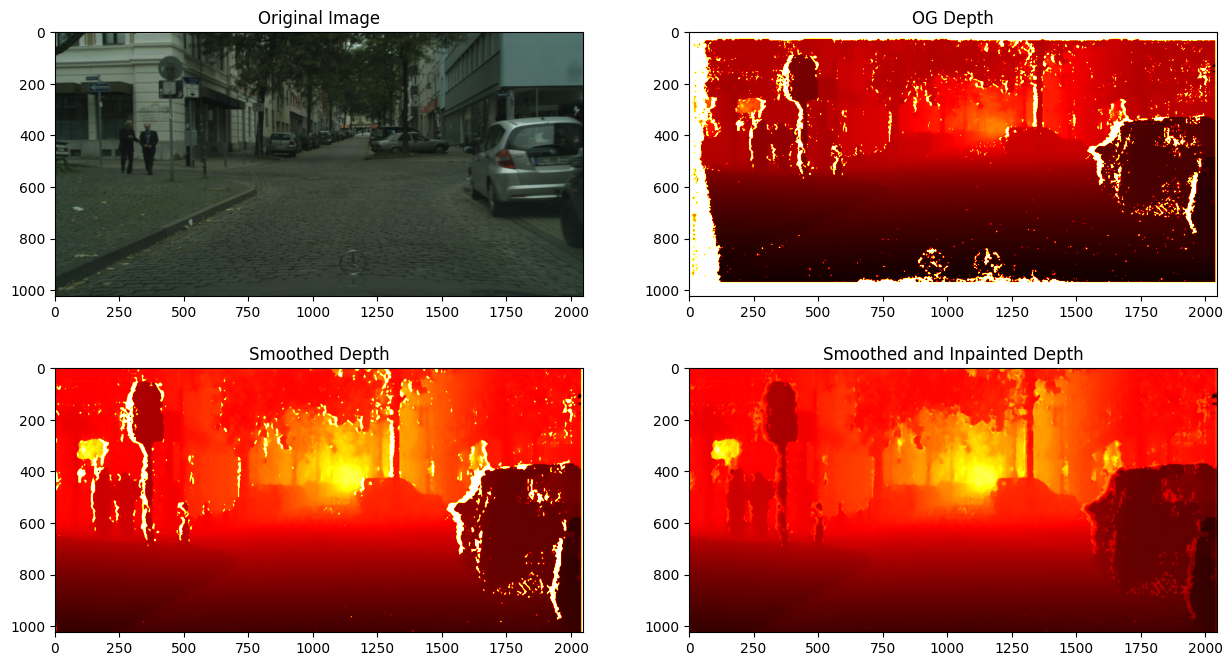

In [72]:
_, ax = plt.subplots(2, 2, figsize=(15, 8))
ax[0, 0].imshow(rgb_image)
ax[0, 0].set_title("Original Image")
ax[0, 1].imshow(np.log(og_depth), cmap='hot')
ax[0, 1].set_title("OG Depth")
ax[1, 0].imshow(np.log(depth1), cmap='hot')
ax[1, 0].set_title("Smoothed Depth")
ax[1, 1].imshow(np.log(depth2), cmap='hot')
ax[1, 1].set_title("Smoothed and Inpainted Depth");